In [62]:
from pymle.models.GeometricBM import GeometricBM
from pymle.core.TransitionDensity import KesslerDensity, ShojiOzakiDensity
from pymle.fit.AnalyticalMLE import AnalyticalMLE
from aleatory.processes import GBM
import numpy as np
import pandas as pd
import yfinance as yf
import warnings
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import lognorm
pd.set_option('display.precision', 4)
warnings.filterwarnings('ignore')

In [53]:
# Define the stock tickers to analyze and the date range for data download.
indices: np.ndarray = np.array(["^AXPJ"])
start_date: str = "2015-01-01"
end_date: str = "2025-5-12"
tickers: np.ndarray = np.concatenate(
    [indices],
    axis=0
)

# Download historical market data once for all specified tickers.
daily_prices: pd.DataFrame = yf.download(", ".join(tickers), start=start_date, end=end_date, actions=True, auto_adjust=False)

daily_closes: pd.DataFrame = daily_prices["Adj Close"].copy()

daily_returns: pd.DataFrame = daily_closes.pct_change(fill_method=None).dropna()

print(daily_returns.mean())
print(daily_returns.std())

[*********************100%***********************]  1 of 1 completed

Ticker
^AXPJ    0.0002
dtype: float64
Ticker
^AXPJ    0.0131
dtype: float64


In [54]:
log_returns = np.log(daily_closes["^AXPJ"] / daily_closes["^AXPJ"].shift(1)).dropna()
annualized_mean_log_ret = log_returns.mean() * 252
annualized_vol_log_ret = log_returns.std() * np.sqrt(252)
print(f"Annualized mean log return: {annualized_mean_log_ret}")
print(f"Annualized volatility of log return: {annualized_vol_log_ret}")

Annualized mean log return: 0.0368856060908123
Annualized volatility of log return: 0.2090243213286862


In [55]:
model = GeometricBM()

# Set bounds for param search, and some psuedo-reasonable initial guess
param_bounds = [(-0.75, 0.75),  (0.01, 2.0)]
guess = np.array([annualized_mean_log_ret, annualized_vol_log_ret])

# ===========================
# Read in the data 
# ===========================

sample = daily_closes["^AXPJ"].values
dt = 1. / 252  # Daily observations

# ===========================
# Fit maximum Likelihood estimators
# ===========================

# Fit using Kessler MLE
kessler_mle = AnalyticalMLE(sample, param_bounds, dt, density=KesslerDensity(model))
kessler_est_result = kessler_mle.estimate_params(guess)
kessler_params = kessler_est_result.params

print(f'\nKessler MLE: {kessler_params} \n')

print

# Fit using Shoji-Ozaki MLE
shojioz_mle = AnalyticalMLE(sample, param_bounds, dt, density=ShojiOzakiDensity(model))
shojioz_est_result = shojioz_mle.estimate_params(guess)
shojioz_params = shojioz_est_result.params

print(f'\nShoji-Ozaki MLE: {shojioz_params}')

Initial Params: [0.03688561 0.20902432]
Initial Likelihood: -11445.047286889343
`xtol` termination condition is satisfied.
Number of iterations: 27, function evaluations: 51, CG iterations: 31, optimality: 9.01e+02, constraint violation: 0.00e+00, execution time: 0.032 s.
Final Params: [0.10902331 0.07228216]
Final Likelihood: -16324.810094446351

Kessler MLE: [0.10902331 0.07228216] 

Initial Params: [0.03688561 0.20902432]
Initial Likelihood: -11395.185225595207
`xtol` termination condition is satisfied.
Number of iterations: 34, function evaluations: 78, CG iterations: 43, optimality: 1.72e+01, constraint violation: 0.00e+00, execution time: 0.028 s.
Final Params: [0.0325889  0.20212591]
Final Likelihood: -11394.277820748826

Shoji-Ozaki MLE: [0.0325889  0.20212591]


Initial Price: 1761.10
Drift (mu): 0.1090
Volatility (sigma): 0.0723
Time Horizon (T): 2.00 years


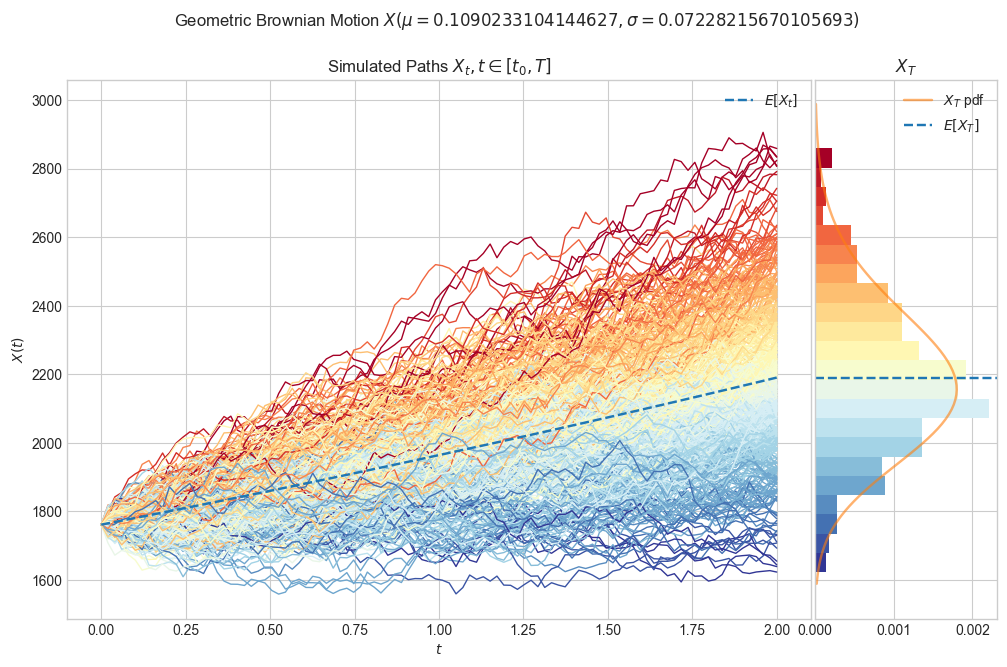

Text(0.5, 0.98, 'GBM with Kessler MLE params: mu=0.1090233104144627, sigma=0.07228215670105693')

In [56]:
mu, sigma = kessler_params
# print(f'\nShoji-Ozaki MLE mu: {mu} \n')
# print(f'Shoji-Ozaki MLE sigma: {sigma} \n')
initial_price = daily_closes["^AXPJ"].iloc[-1]
paths = 10000
steps = 504
dt = 1. / 252  # Daily observations
T = steps * dt # Total simulation time in years

print(f"Initial Price: {initial_price:.2f}")
print(f"Drift (mu): {mu:.4f}")
print(f"Volatility (sigma): {sigma:.4f}")
print(f"Time Horizon (T): {T:.2f} years")

process = GBM(drift=mu, volatility=sigma, initial=initial_price, T=T)

fig = process.draw(n=100, N=500, figsize=(12, 7))
fig.suptitle(f"GBM with Kessler MLE params: mu={mu}, sigma={sigma}", fontsize=16)

In [57]:
# Summary Statistics
simulated_paths = process.simulate(n=steps, N=paths)
time = process.times 

means = np.mean(simulated_paths, axis=0)
stds = np.std(simulated_paths, axis=0)

quantiles_to_calculate = [0.05, 0.50, 0.95]
temp_quantiles_list = []
for q_val in quantiles_to_calculate:
    temp_quantiles_list.append(np.quantile(simulated_paths, q_val, axis=0))
quantiles = np.array(temp_quantiles_list)

th_means_all_t = process.marginal_expectation(times=time)
th_vars_all_t = process.marginal_variance(times=time)
th_stds_all_t = np.sqrt(th_vars_all_t)

df = []

for i, t in enumerate(time):
    th_mean = th_means_all_t[i]
    th_var = th_vars_all_t[i]
    th_std_dev = th_stds_all_t[i]
    
    est_mean_t = means[i]
    est_std_t = stds[i]
    
    est_q05_t = quantiles[0, i] 
    est_q50_t = quantiles[1, i] 
    est_q95_t = quantiles[2, i] 
    
    df.append({
        "Time": t, 
        "Th. Mean": th_mean,
        "Th. Std Dev": th_std_dev,
        "Th. Variance": th_var,
        "Est. Mean": est_mean_t,
        "Est. Std Dev": est_std_t,
        "Est. Q5": est_q05_t,
        "Est. Q50": est_q50_t,
        "Est. Q95": est_q95_t,
    })

df = pd.DataFrame(df).set_index("Time")
print(df)

         Th. Mean  Th. Std Dev  Th. Variance  Est. Mean  Est. Std Dev  \
Time                                                                    
0.0000  1761.1000       0.0000        0.0000  1761.1000        0.0000   
0.0040  1761.8636       8.0304       64.4872  1761.9235        7.9571   
0.0080  1762.6275      11.3617      129.0875  1762.7290       11.3189   
0.0119  1763.3917      13.9213      193.8013  1763.4767       13.9173   
0.0159  1764.1563      16.0819      258.6285  1764.4536       16.1378   
...           ...          ...           ...        ...           ...   
1.9841  2186.3888     223.1856    49811.8335  2186.6934      224.5823   
1.9881  2187.3368     223.5072    49955.4680  2187.5570      224.7794   
1.9920  2188.2852     223.8288    50099.3163  2188.5649      225.3485   
1.9960  2189.2340     224.1503    50243.3786  2189.5666      225.5276   
2.0000  2190.1833     224.4719    50387.6553  2190.4352      225.8001   

          Est. Q5   Est. Q50   Est. Q95  
Time    

In [71]:
def plot_gbm_pdf_surface(s0, mu, sigma, t_max, n_t_pts=40, n_s_pts=80, s_range_stds=1.5):
    t_mesh_pts = np.linspace(1e-5, t_max, n_t_pts) 
    log_s0 = np.log(s0)

    final_mu_log = log_s0 + (mu - 0.5 * sigma**2) * t_max
    final_sigma_log = sigma * np.sqrt(t_max)

    if final_sigma_log < 1e-5: 
        s_center = s0 * np.exp(mu * t_max)
        s_mesh_pts = np.linspace(max(1e-6, s_center * 0.7), s_center * 1.3, n_s_pts)
    else:
        s_min_log = final_mu_log - s_range_stds * final_sigma_log
        s_max_log = final_mu_log + s_range_stds * final_sigma_log
        s_mesh_pts = np.geomspace(max(1e-6, np.exp(s_min_log)), np.exp(s_max_log), n_s_pts)

    T_grid, S_grid = np.meshgrid(t_mesh_pts, s_mesh_pts)
    PDF_grid = np.zeros_like(T_grid)

    for j, t_val in enumerate(t_mesh_pts):
        mu_log_t = log_s0 + (mu - 0.5 * sigma**2) * t_val
        sigma_log_t = sigma * np.sqrt(t_val)
        
        if sigma_log_t < 1e-5 : 
            if len(s_mesh_pts) > 1 and (s_mesh_pts[-1] - s_mesh_pts[0]) > 0:
                price_at_t = s0 * np.exp(mu * t_val)
                idx_closest_s = np.argmin(np.abs(s_mesh_pts - price_at_t))
                avg_s_step = (s_mesh_pts[-1] - s_mesh_pts[0]) / (len(s_mesh_pts) -1) if len(s_mesh_pts) > 1 else 1.0
                PDF_grid[idx_closest_s, j] = 1.0 / avg_s_step if avg_s_step > 0 else 1.0
        else:
            PDF_grid[:, j] = lognorm.pdf(s_mesh_pts, s=sigma_log_t, scale=np.exp(mu_log_t))

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(T_grid, S_grid, PDF_grid, cmap='viridis', rstride=1, cstride=1, alpha=0.95, edgecolor='none')
    
    ax.set_xlabel('Time (t)')
    ax.set_ylabel('Stock Price ($S_t$)')
    ax.set_zlabel('Probability Density $f(S_t, t)$')
    ax.set_title(f'GBM PDF Surface ($S_0={s0:.1f}, \\mu={mu:.2f}, \\sigma={sigma:.2f}$)', fontsize=14)
    fig.colorbar(surf, shrink=0.5, aspect=8, label='Density')
    ax.view_init(elev=25, azim=-130) 
    plt.tight_layout()
    plt.show()

def plot_price_sensitivity_mu_sigma(s0, t_fixed, base_mu, base_sigma, 
                                mu_rel_range=0.75, sigma_rel_range=0.75, n_pts=30):
    mu_offset = abs(base_mu * mu_rel_range) if base_mu != 0 else (0.1 * mu_rel_range)
    mu_space = np.linspace(base_mu - mu_offset, base_mu + mu_offset, n_pts)

    sigma_offset = base_sigma * sigma_rel_range
    sigma_min = max(1e-3, base_sigma - sigma_offset)
    sigma_space = np.linspace(sigma_min, base_sigma + sigma_offset, n_pts)

    MU_grid, SIGMA_grid = np.meshgrid(mu_space, sigma_space)

    median_s_t_values = s0 * np.exp((MU_grid - 0.5 * SIGMA_grid**2) * t_fixed)

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(MU_grid, SIGMA_grid, median_s_t_values, cmap='plasma', rstride=1, cstride=1, edgecolor='none', alpha=0.9)

    ax.set_xlabel('Drift ($\\mu$)')
    ax.set_ylabel('Volatility ($\\sigma$)')
    ax.set_zlabel(f'Median Stock Price at T={t_fixed:.2f}')
    title_str = (f'Sensitivity of Median $S_T$\n'
                    f'$S_0={s0:.1f}, T={t_fixed:.1f}$, Base $(\\mu={base_mu:.2f}, \\sigma={base_sigma:.2f})$')
    ax.set_title(title_str, fontsize=14)
    fig.colorbar(surf, shrink=0.5, aspect=8, label=f'Median $S_T$')
    ax.view_init(elev=25, azim=-60) 
    plt.tight_layout()
    plt.show()

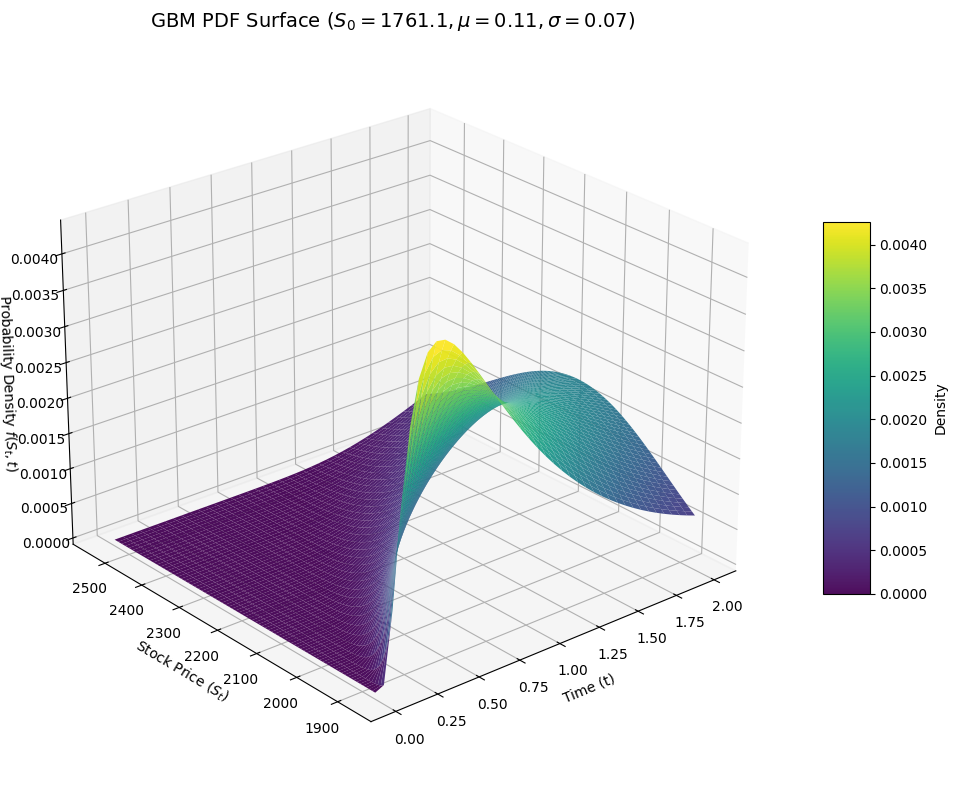

In [72]:
plot_gbm_pdf_surface(s0=initial_price, mu=mu, sigma=sigma, t_max=T)

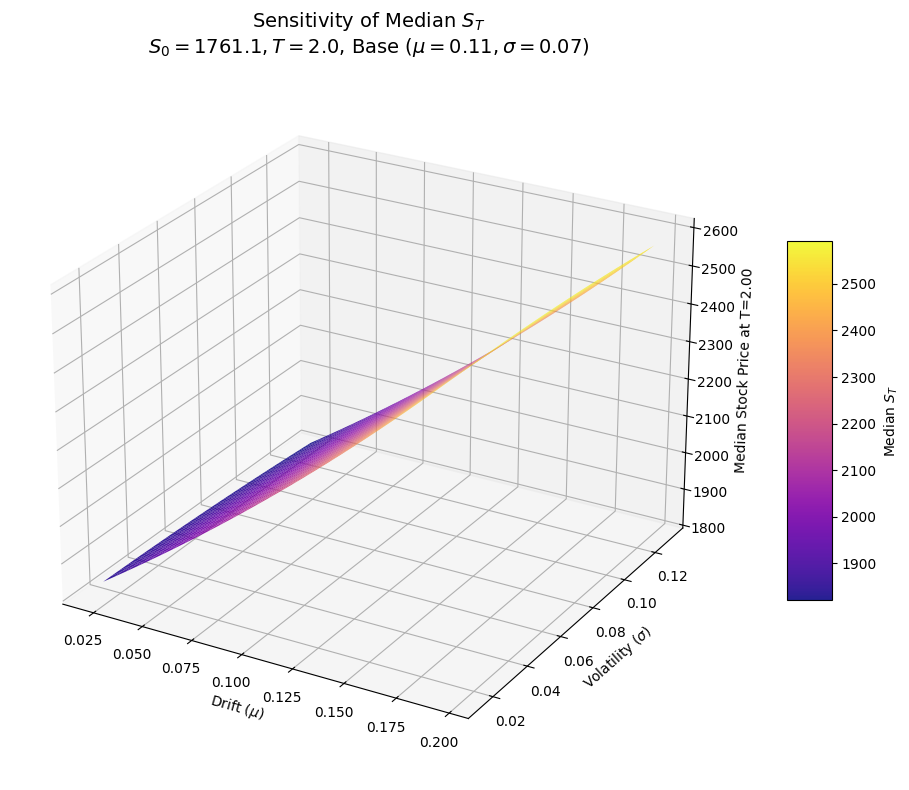

In [73]:
plot_price_sensitivity_mu_sigma(s0=initial_price, 
                                t_fixed=T, 
                                base_mu=mu, 
                                base_sigma=sigma,
                                mu_rel_range=0.8,   
                                sigma_rel_range=0.8
                               ) 